In [5]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow_probability as tfp
from anesthetic.plot import kde_contour_plot_2d
import numpy as np
import matplotlib.pyplot as plt
from anesthetic import read_chains
from betaflows.betaflows import BetaFlow
from betaflows.utils import get_beta_schedule, approx_uniform_prior_bounds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
nbeta_samples = 10
nmixtures = 5
nRepeats = 5
ndims = [2, 4, 6, 8]
NUMBER_NETS = 6
HIDDEN_LAYERS = [50]
bepochs = 10000
mepochs = 10000
LOAD = False

base_dir = 'mixture_models/'


ndims =  2


 57%|█████▋    | 5737/10000 [00:47<00:35, 120.08it/s]


Early stopped. Epochs used = 5737. Minimum at epoch = 5487


  8%|▊         | 765/10000 [00:02<00:32, 281.88it/s]


Early stopped. Epochs used = 765. Minimum at epoch = 565


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


nflp:  0.37799354590263096
cnflp:  0.512339932554035


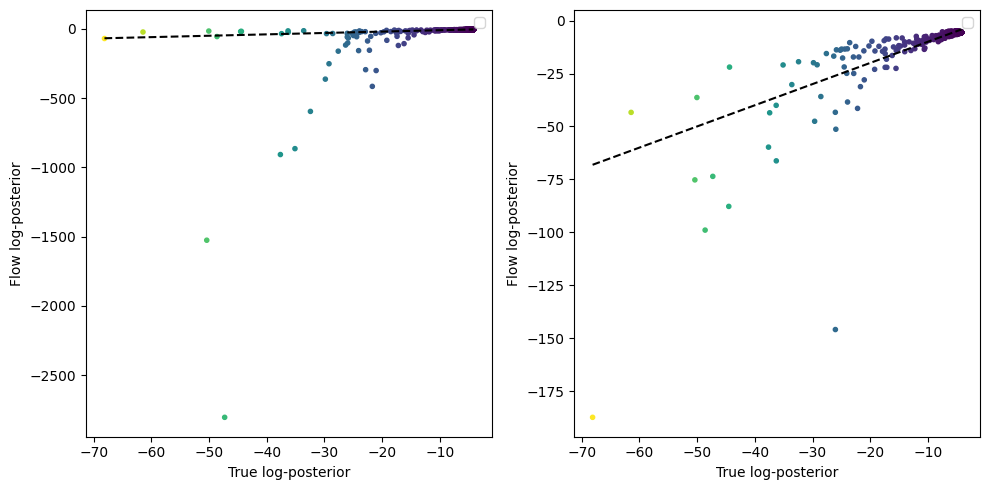

ndims =  4


 26%|██▋       | 2632/10000 [00:48<02:16, 53.90it/s]


KeyboardInterrupt: 

In [7]:
nflpRepeats, cnflpRepeats = [], []
for r in range(nRepeats):
    cnflp_error, nflp_error = [], []
    for i, n in enumerate(ndims):
        print("ndims = ", n)
        chains = read_chains(base_dir + f'ndims_{n}_nmixtures_{nmixtures}/test')

        beta = get_beta_schedule(chains, nbeta_samples)

        theta, sample_weights, beta_values = [], [], []
        for j,b in enumerate(beta):
            if j > 0:
                s = chains.set_beta(b)
                theta.append(s.values[:, :n])
                sample_weights.append(s.get_weights()/s.get_weights().sum())
                beta_values.append([np.log10(b)]*len(s.get_weights()))
        theta = np.concatenate(theta).astype(np.float32)
        sample_weights = np.concatenate(sample_weights).astype(np.float32)
        conditional = np.concatenate(beta_values).astype(np.float32)

        if LOAD:
            try:
                bflow = BetaFlow.load(base_dir + f'ndims_{n}_nmixtures_{nmixtures}/beta_flow_{r}.pkl')
            except FileNotFoundError:
                bflow = BetaFlow(theta, weights=sample_weights, 
                                theta_min=np.array([-25]*n).astype(np.float32),
                                theta_max=np.array([25]*n).astype(np.float32),
                    number_networks=NUMBER_NETS, hidden_layers=HIDDEN_LAYERS,)
                bflow.training(conditional, epochs=bepochs,
                                early_stop=True, patience=250,
                                loss_type='mean')
                bflow.save(base_dir + f'ndims_{n}_nmixtures_{nmixtures}/beta_flow_{r}.pkl')
        else:
            bflow = BetaFlow(theta, weights=sample_weights, 
                            theta_min=np.array([-25]*n).astype(np.float32), 
                            theta_max=np.array([25]*n).astype(np.float32),
                number_networks=NUMBER_NETS, hidden_layers=HIDDEN_LAYERS,)
            bflow.training(conditional, epochs=bepochs,
                            early_stop=True, patience=250,
                            loss_type='mean')
            bflow.save(base_dir + f'ndims_{n}_nmixtures_{nmixtures}/beta_flow_{r}.pkl')

        from margarine.maf import MAF

        values = chains.values[:, :n]
        weights = chains.get_weights()
        weights = weights/weights.sum()

        if LOAD:
            try:
                flow = MAF.load(base_dir + f'ndims_{n}_nmixtures_{nmixtures}/normal_flow_{r}.pkl')
            except FileNotFoundError:
                flow = MAF(values, weights=weights, 
                        theta_min=np.array([-25]*n).astype(np.float32), 
                        theta_max=np.array([25]*n).astype(np.float32), 
                    number_networks=NUMBER_NETS,
                    hidden_layers=HIDDEN_LAYERS)
                flow.train(mepochs, early_stop=True,
                           loss_type='mean')
                flow.save(base_dir + f'ndims_{n}_nmixtures_{nmixtures}/normal_flow_{r}.pkl')
        else:
            flow = MAF(values, weights=weights, 
                    theta_min=np.array([-25]*n).astype(np.float32), 
                    theta_max=np.array([25]*n).astype(np.float32),
                number_networks=NUMBER_NETS,
                hidden_layers=HIDDEN_LAYERS)
            flow.train(mepochs, early_stop=True, loss_type='mean')
            flow.save(base_dir + f'ndims_{n}_nmixtures_{nmixtures}/normal_flow_{r}.pkl')

        prior_log_prob = np.log(np.prod([1/50]*n))
        
        posterior_probs = chains['logL'] + prior_log_prob - chains.stats(1000)['logZ'].mean()

        nflp = flow.log_prob(values).numpy()
        cnflp = bflow.log_prob(values, np.log10(1))

        mask = np.isfinite(nflp) & np.isfinite(cnflp)
        nflp = nflp[mask]
        cnflp = cnflp[mask]
        weights = weights[mask]

        pps = posterior_probs.values[mask]

        nflp_error.append(np.average(pps - nflp, weights=weights))
        cnflp_error.append(np.average(pps - cnflp, weights=weights))

        print('nflp: ', nflp_error[-1])
        print('cnflp: ', cnflp_error[-1])

        if r == 0:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            
            axes[0].scatter(posterior_probs, nflp, marker='.', c=posterior_probs, cmap='viridis_r')
            axes[1].scatter(posterior_probs, cnflp, marker='.', c=posterior_probs, cmap='viridis_r')

            for j in range(2):
                axes[j].plot(posterior_probs, posterior_probs, linestyle='--', color='k')
                axes[j].set_xlabel('True log-posterior')
                axes[j].set_ylabel('Flow log-posterior')
                axes[j].legend()
                #axes[j].set_ylim(posterior_probs.min()*2, 10)
            
            """for j in range(len(nflp)):
                if nflp[j] < posterior_probs.min()*2:
                    norm_prob = (posterior_probs[j] - posterior_probs.min())/ \
                            (posterior_probs.max() - posterior_probs.min())
                    axes[0].arrow(posterior_probs[j], posterior_probs.min()*0.5, 
                                0, -50, head_width=posterior_probs.min()*0.1, 
                                head_length=posterior_probs.min()*0.05, 
                                fc=plt.get_cmap('viridis_r')(norm_prob),
                                ec='k',#plt.get_cmap('viridis_r')(norm_prob),
                                lw=0.4)
                if cnflp[j] < posterior_probs.min()*10:
                    axes[1].arrow(posterior_probs[j], posterior_probs.min()*0.5, 
                                0, -50, head_width=posterior_probs.min()*0.1, 
                                head_length=posterior_probs.min()*0.05,
                                fc=plt.get_cmap('viridis_r')(norm_prob),
                                ec='k',#plt.get_cmap('viridis_r')(norm_prob),
                                lw=0.4)"""
                
            plt.tight_layout()
            plt.savefig(base_dir + f'ndims_{n}_nmixtures_{nmixtures}/likleihood_comparison_{r}.png', dpi=300)
            plt.show()
    nflpRepeats.append(nflp_error)
    cnflpRepeats.append(cnflp_error)
nflpRepeats = np.array(nflpRepeats)
cnflpRepeats = np.array(cnflpRepeats)


(5, 4)
(5, 4)


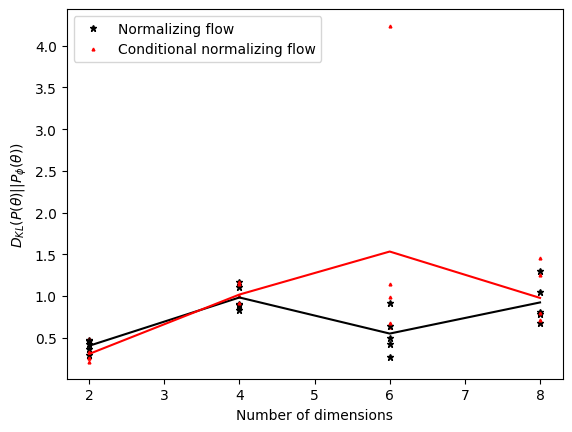

In [4]:

print(nflpRepeats.shape)
print(cnflpRepeats.shape)
for i in range(nRepeats-1):
    plt.plot(ndims, nflpRepeats[i, :], ls='', c='k', marker='*', ms=5, label='_Normalizing flow')
    plt.plot(ndims, cnflpRepeats[i, :], ls='', c='r', marker='^', ms=2, label='_Conditional normalizing flow')
plt.plot(ndims, nflpRepeats[nRepeats-1, :], ls='', c='k', marker='*',ms=5, label='Normalizing flow')
plt.plot(ndims, cnflpRepeats[nRepeats-1, :], ls='', c='r', marker='^',ms=2, label='Conditional normalizing flow')
plt.plot(ndims, np.mean(nflpRepeats, axis=0), c='k', label='_Normalizing flow')
plt.plot(ndims, np.mean(cnflpRepeats, axis=0), c='r', label='_Conditional normalizing flow')
plt.xlabel('Number of dimensions')
plt.ylabel(r'$D_{KL}(P(\theta)||P_\phi(\theta))$')
plt.legend()
plt.show()